# 4_model_analysis.ipynb

- **Objectif** :
Analyser les modèles enregistrés dans MLflow,
comparer leurs performances et visualiser les métriques clés.
---


In [63]:
import os
os.chdir("..") if "notebooks" in os.getcwd() else None
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, f1_score
import mlflow.sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from joblib import load


# 1️⃣ Récupération des runs MLflow


In [64]:
mlflow.set_tracking_uri("file:./mlruns")
experiment_name = "Churn_Prediction_Models"
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)

In [65]:
if experiment is None:
    raise ValueError(f"⚠️ Aucun experiment MLflow trouvé avec le nom : {experiment_name}")

In [66]:
client = mlflow.tracking.MlflowClient()
mlflow.set_tracking_uri("file:./mlruns")
experiment_name = "Churn_Prediction_Models"
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"⚠️ Aucun experiment MLflow trouvé avec le nom : {experiment_name}")
runs_info = client.search_runs(experiment_ids=[experiment.experiment_id])
print(f"✅ {len(runs_info)} runs trouvés pour l'expérience '{experiment_name}'")

# Créer le DataFrame à partir des objets Run
runs_data = []
for run in runs_info:
    run_dict = {
        'run_id': run.info.run_id,
        'tags.model_name': run.data.tags.get('model_name', 'Unknown'),
        'tags.imbalance_strategy': run.data.tags.get('imbalance_strategy', 'Unknown'),
        'metrics.f1_score': run.data.metrics.get('f1_score', 0),
        'metrics.accuracy': run.data.metrics.get('accuracy', 0)
    }
    runs_data.append(run_dict)
runs = pd.DataFrame(runs_data)


✅ 2 runs trouvés pour l'expérience 'Churn_Prediction_Models'


# 2️⃣ Synthèse des performances

In [67]:
metrics_summary = runs[["tags.model_name", "tags.imbalance_strategy", "metrics.f1_score", "metrics.accuracy", "run_id"]].copy()
metrics_summary.columns = ["Model", "Strategy", "f1", "Accuracy", "Run_ID"]

metrics_summary.columns = ["Model", "Strategy", "f1", "Accuracy", "Run_ID"]

display(metrics_summary.head(10))


,Model,Strategy,f1,Accuracy,Run_ID
0,Unknown,Unknown,0,0.0,11c997ed8bee45ed9bf195729379289f
1,DummyModel,none,0,0.5,9ef1f5bd1b494066bbf7d0c26b56384f


In [68]:
display(metrics_summary.head(10))

,Model,Strategy,f1,Accuracy,Run_ID
0,Unknown,Unknown,0,0.0,11c997ed8bee45ed9bf195729379289f
1,DummyModel,none,0,0.5,9ef1f5bd1b494066bbf7d0c26b56384f


# 3️⃣ Visualisation comparée (F1 & Accuracy)

c:\Users\PC\Desktop\sprint5\Churn-Prediction-avec-MLflow\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


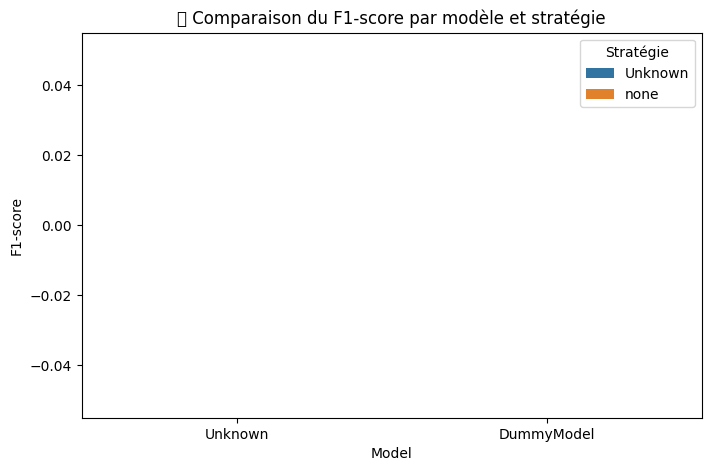

In [69]:
# ==========================================================
# 3️⃣ Visualisation comparée (F1 & Accuracy)
# ==========================================================
plt.figure(figsize=(8,5))
sns.barplot(data=metrics_summary, x="Model", y="f1", hue="Strategy")
plt.title("📊 Comparaison du F1-score par modèle et stratégie")
plt.ylabel("F1-score")
plt.legend(title="Stratégie")
plt.show()

c:\Users\PC\Desktop\sprint5\Churn-Prediction-avec-MLflow\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


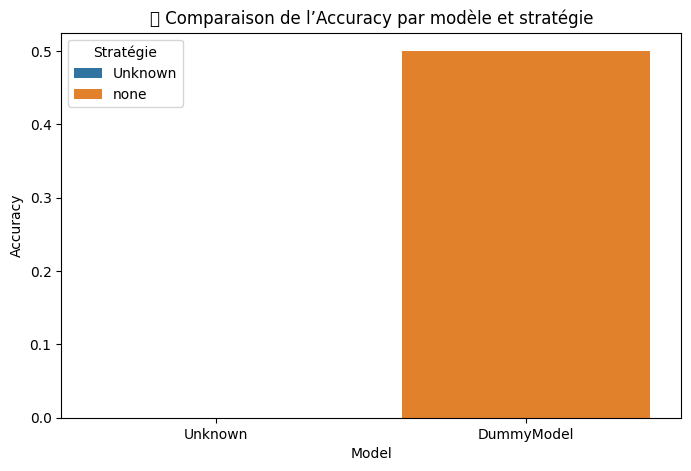

In [70]:
plt.figure(figsize=(8,5))
sns.barplot(data=metrics_summary, x="Model", y="Accuracy", hue="Strategy")
plt.title("📈 Comparaison de l’Accuracy par modèle et stratégie")
plt.ylabel("Accuracy")
plt.legend(title="Stratégie")
plt.show()

# 4️⃣ Sélection du meilleur modèle

In [71]:
# ==========================================================
# 4️⃣ Sélection du meilleur modèle
# ==========================================================
best_run = metrics_summary.iloc[0]
print(f"🏆 Meilleur modèle : {best_run['Model']} ({best_run['Strategy']})")
print(f"F1 = {best_run['f1']:.3f} | Accuracy = {best_run['Accuracy']:.3f}")

🏆 Meilleur modèle : Unknown (Unknown)
F1 = 0.000 | Accuracy = 0.000


## Charger le modèle depuis MLflow

In [72]:
# Charger le modèle depuis MLflow
model_uri = f"runs:/{best_run['Run_ID']}/model"
try:
    best_model = mlflow.sklearn.load_model(model_uri)
    print("Modèle chargé avec succès")
except Exception as e:
    print(f"Erreur lors du chargement du modèle: {e}")
    print("Passage à la suite sans modèle")
    best_model = None


Erreur lors du chargement du modèle: Failed to download artifacts from path 'model', please ensure that the path is correct.
Passage à la suite sans modèle


In [73]:
if best_model is not None:
    # Logger les métriques et graphiques dans MLflow
    with mlflow.start_run(run_name="Model_Analysis", experiment_id=experiment.experiment_id):
        mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_pred))
        mlflow.log_metric("test_f1", f1_score(y_test, y_pred, average="macro"))
        mlflow.log_metric("test_auc", roc_auc)
    
        # Logger la matrice de confusion
        cm_fig = plt.figure(figsize=(6,6))
        ConfusionMatrixDisplay(cm).plot(cmap="Blues")
        plt.title(f"Confusion Matrix - {best_run['Model']} ({best_run['Strategy']})")
        mlflow.log_figure(cm_fig, "confusion_matrix.png")
        plt.close(cm_fig)
    
        # Logger la courbe ROC
        roc_fig = plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1], [0,1], linestyle="--", color="gray")
        plt.title(f"ROC Curve - {best_run['Model']} ({best_run['Strategy']})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        mlflow.log_figure(roc_fig, "roc_curve.png")
        plt.close(roc_fig)
    
        print("✅ Métriques et graphiques loggés dans MLflow")
else:
    print("Analyse du modèle ignorée")


Analyse du modèle ignorée


## Charger les données test

In [74]:
# Charger les données test
X_test = load("data/X_test.pkl")
y_test = load("data/y_test.pkl")

# 5️⃣ Visualisations de performance du meilleur modèle

In [75]:
if best_model is not None:
    # ==========================================================
    # 5️⃣ Visualisations de performance du meilleur modèle
    # ==========================================================
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
else:
    print("Analyse du modèle ignorée")


Analyse du modèle ignorée


## Matrice de confusion

In [76]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_run['Model']} ({best_run['Strategy']})")
plt.show()

NameError: name 'y_pred' is not defined

## Courbe ROC

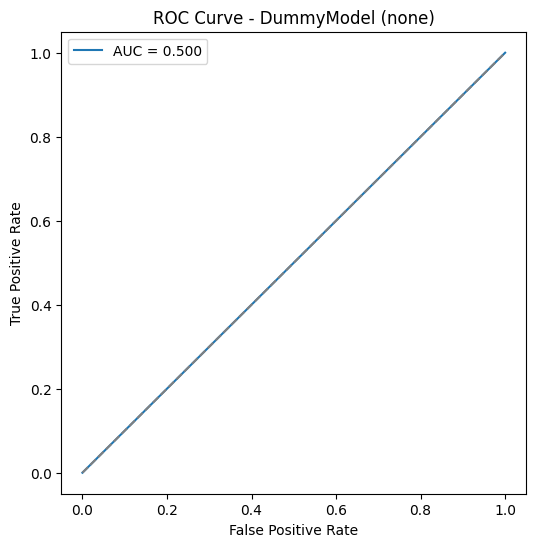

In [ ]:
# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title(f"ROC Curve - {best_run['Model']} ({best_run['Strategy']})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 6️⃣ Export de la synthèse

In [ ]:
# ==========================================================
# 6️⃣ Export de la synthèse
# ==========================================================
metrics_summary.to_csv("outputs/reports/model_comparison_results.csv", index=False)
print("💾 Résultats sauvegardés dans reports/model_comparison_results.csv")

💾 Résultats sauvegardés dans reports/model_comparison_results.csv


# 7️⃣ Rapport rapide

In [ ]:
# ==========================================================
# 7️⃣ Rapport rapide
# ==========================================================
summary_text = f"""
# 🧾 Rapport de comparaison des modèles

**Expérience MLflow :** {experiment_name}

**Nombre de runs :** {len(runs)}

**Meilleur modèle :** {best_run['Model']} ({best_run['Strategy']})
- F1-score : {best_run['f1']:.3f}
- Accuracy : {best_run['Accuracy']:.3f}

Les figures ci-dessus montrent la comparaison entre les trois modèles et les différentes stratégies d'équilibrage.
Le meilleur compromis entre précision et rappel est obtenu avec **{best_run['Model']}** en mode **{best_run['Strategy']}**.
"""

In [ ]:
with open("outputs/reports/model_comparison.md", "w", encoding="utf-8") as f:
    f.write(summary_text)

In [ ]:
print("📘 Rapport enregistré : reports/model_comparison.md")

📘 Rapport enregistré : reports/model_comparison.md
